# Fuzzy Control Systems: The Tipping Problem

The ‘tipping problem’ is commonly used to illustrate the power of fuzzy logic principles to generate complex behavior from a compact, intuitive set of expert rules. See the **Introduction.md** document for an intro.

# Creating the Tipping Controller Using the `skfuzzy` Control API

We can use the `skfuzzy` control system API to model this. First, let’s define the fuzzy variables.


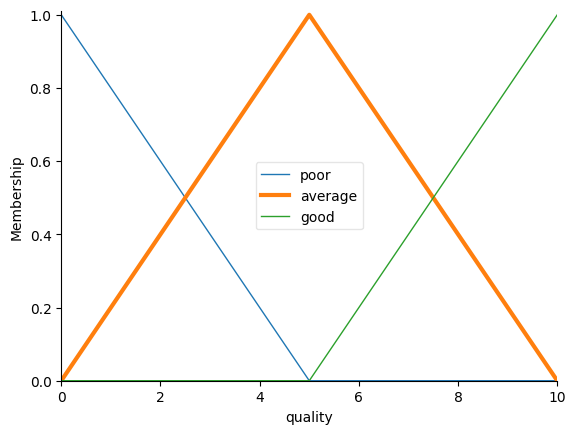

In [2]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
quality = ctrl.Antecedent(np.arange(0, 11, 1), 'quality')
service = ctrl.Antecedent(np.arange(0, 11, 1), 'service')
tip = ctrl.Consequent(np.arange(0, 26, 1), 'tip')

# Auto-membership function population is possible with .automf(3, 5, or 7)
quality.automf(3)
service.automf(3)

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
tip['low'] = fuzz.trimf(tip.universe, [0, 0, 13])
tip['medium'] = fuzz.trimf(tip.universe, [0, 13, 25])
tip['high'] = fuzz.trimf(tip.universe, [13, 25, 25])

# You can see how these look with .view()
quality['average'].view()

/Users/kiansahafi/Desktop/Classes/fuzzy systems class/fuzzy-tutorial/venv/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


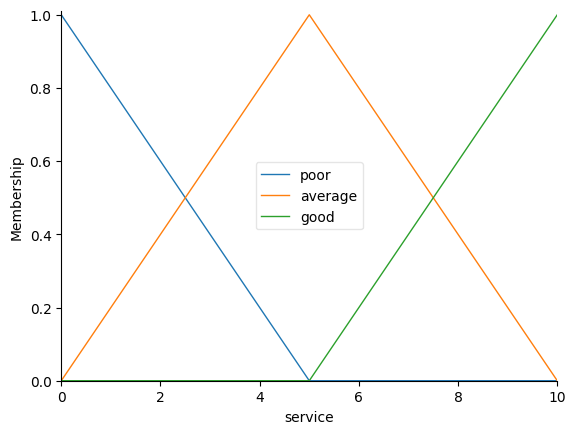

In [3]:
service.view()


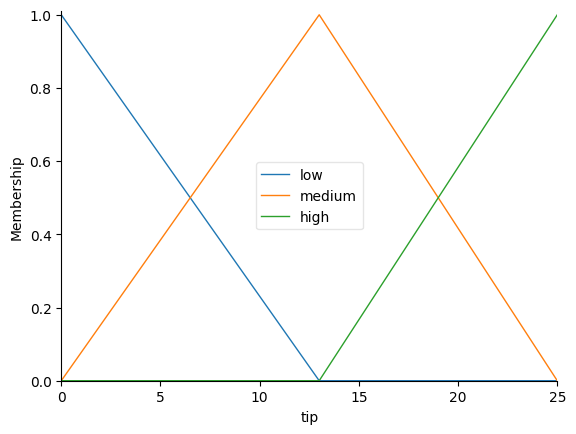

In [4]:
tip.view()


# Fuzzy Rules

Now, to make these triangles useful, we define the fuzzy relationship between input and output variables. For the purposes of our example, consider three simple rules:

1. **If the food is poor OR the service is poor, then the tip will be low.**
2. **If the service is average, then the tip will be medium.**
3. **If the food is good OR the service is good, then the tip will be high.**

Most people would agree on these rules, but the rules are fuzzy. Mapping the imprecise rules into a defined, actionable tip is a challenge. This is the kind of task at which fuzzy logic excels.


(<Figure size 640x480 with 1 Axes>, <Axes: >)

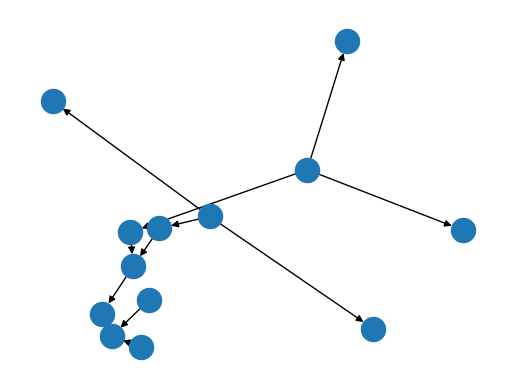

In [5]:
rule1 = ctrl.Rule(quality['poor'] | service['poor'], tip['low'])
rule2 = ctrl.Rule(service['average'], tip['medium'])
rule3 = ctrl.Rule(service['good'] | quality['good'], tip['high'])

rule1.view()

# Control System Creation and Simulation

Now that we have our rules defined, we can simply create a control system via:

In [6]:
tipping_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])


In order to simulate this control system, we will create a `ControlSystemSimulation`. Think of this object as representing our controller applied to a specific set of circumstances. For tipping, this might be tipping Sharon at the local brew-pub. We would create another `ControlSystemSimulation` when we’re trying to apply our `tipping_ctrl` for Travis at the cafe because the inputs would be different.


In [7]:
tipping = ctrl.ControlSystemSimulation(tipping_ctrl)


We can now simulate our control system by simply specifying the inputs and calling the `compute` method. Suppose we rated the quality 6.5 out of 10 and the service 9.8 out of 10.


19.847607361963195


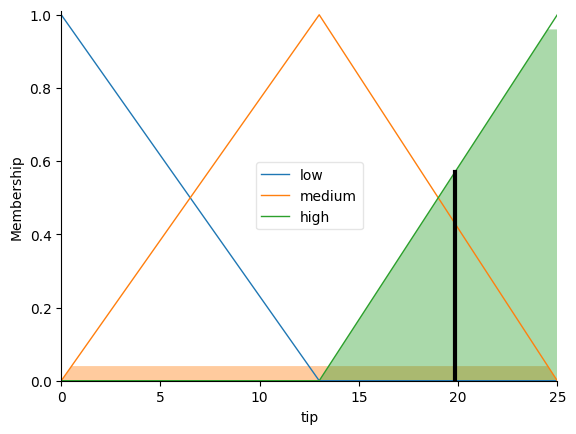

In [8]:
# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
tipping.input['quality'] = 6.5
tipping.input['service'] = 9.8

# Crunch the numbers
tipping.compute()

# Once computed, we can view the result as well as visualize it.

print(tipping.output['tip'])
tip.view(sim=tipping)


# Defuzzification

Fuzzy logic calculations are excellent tools, but to use them the fuzzy result must be converted back into a single number. This is known as defuzzification.
There are several possible methods for defuzzification, exposed via skfuzzy.defuzz.

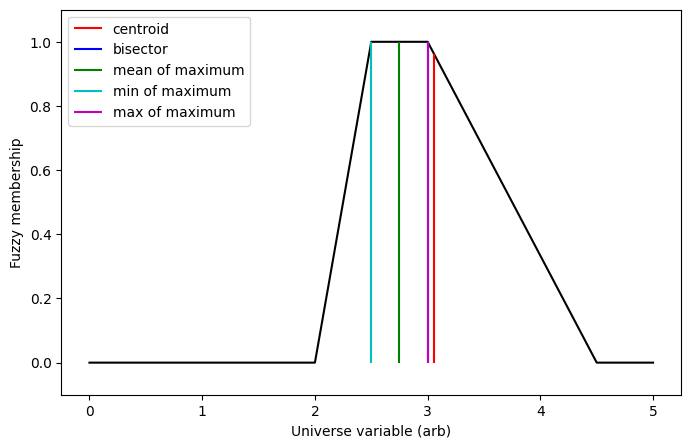

In [9]:
import matplotlib.pyplot as plt

# Generate trapezoidal membership function on range [0, 1]
x = np.arange(0, 5.05, 0.1)
mfx = fuzz.trapmf(x, [2, 2.5, 3, 4.5])

# Defuzzify this membership function five ways
defuzz_centroid = fuzz.defuzz(x, mfx, 'centroid')  # Same as skfuzzy.centroid
defuzz_bisector = fuzz.defuzz(x, mfx, 'bisector')
defuzz_mom = fuzz.defuzz(x, mfx, 'mom')
defuzz_som = fuzz.defuzz(x, mfx, 'som')
defuzz_lom = fuzz.defuzz(x, mfx, 'lom')

# Collect info for vertical lines
labels = ['centroid', 'bisector', 'mean of maximum', 'min of maximum',
          'max of maximum']
xvals = [defuzz_centroid,
         defuzz_bisector,
         defuzz_mom,
         defuzz_som,
         defuzz_lom]
colors = ['r', 'b', 'g', 'c', 'm']
ymax = [fuzz.interp_membership(x, mfx, i) for i in xvals]

# Display and compare defuzzification results against membership function
plt.figure(figsize=(8, 5))

plt.plot(x, mfx, 'k')
for xv, y, label, color in zip(xvals, ymax, labels, colors):
    plt.vlines(xv, 0, y, label=label, color=color)
plt.ylabel('Fuzzy membership')
plt.xlabel('Universe variable (arb)')
plt.ylim(-0.1, 1.1)
plt.legend(loc=2)

plt.show()